In [422]:
from pyforest import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from pyarrow.feather import (read_feather as read_dataframe,  # noqa
                             write_feather as write_dataframe,
                             FeatherError,
                             FeatherReader,
                             FeatherWriter)
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from category_encoders import *
from sklearn.model_selection import KFold, TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [2]:
train = pd.read_csv('train_transaction.csv')
train_id = pd.read_csv('train_identity.csv')
test = pd.read_csv('test_transaction.csv')
test_id = pd.read_csv('test_identity.csv')

In [3]:
write_dataframe(train, 'train_transaction.feather')
train = read_dataframe('train_transaction.feather')
write_dataframe(train_id, 'train_id.feather')
train_id = read_dataframe('train_id.feather')
write_dataframe(test, 'test.feather')
test = read_dataframe('test.feather')
write_dataframe(test_id, 'test_id.feather')
test_id = read_dataframe('test_id.feather')

In [4]:
y_train = train['isFraud']
df = pd.concat([train, test], axis=0, sort = False).reset_index().drop('index', axis=1)
df_id = pd.concat([train_id, test_id], axis=0, sort = False).reset_index().drop('index', axis=1)

In [5]:
df['decimal'] = df['TransactionAmt'].apply(lambda x: len(str(x).split('.')[1]))

In [275]:
len(test)

506691

In [7]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [8]:
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'decimal'],
      dtype='object', length=395)

In [9]:
v_feature = [x for x in df.columns if 'V' in x]
for col in v_feature:
    df[col].fillna(df[col].mean() -2, inplace = True)
    df[col] = minmax_scale(df[col], feature_range = [0,1])

df = PCA_change(df, v_feature, prefix='PCA_V_', n_components=35)

columns = ['PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5', 
           'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9', 'PCA_V_10', 'PCA_V_11', 
           'PCA_V_12', 'PCA_V_13', 'PCA_V_14', 'PCA_V_15', 'PCA_V_16', 
           'PCA_V_17', 'PCA_V_18', 'PCA_V_19', 'PCA_V_20', 'PCA_V_21', 
           'PCA_V_22', 'PCA_V_23', 'PCA_V_24', 'PCA_V_25', 'PCA_V_26', 
           'PCA_V_27', 'PCA_V_28', 'PCA_V_29', 'PCA_V_30', 'PCA_V_31', 
           'PCA_V_32', 'PCA_V_33', 'PCA_V_34']


In [194]:
df_id.head()

,TransactionID,id_01,id_02,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_32,id_34,id_35,id_37,id_38,DeviceType,device_name,device_version,OS_id_30,version_id_30,screen_width,screen_height,browser_id_31,version_id_31
0,2987004,0.0,70787.0,NotFound,42.415219,-480.0,New,NotFound,166.0,-1.0,542.0,144.0,New,NotFound,32.0,2,T,T,T,mobile,Samsung,NRD90M,Android,7.0,2220,1080,samsung,browser
1,2987008,-5.0,98945.0,NotFound,49.000000,-300.0,New,NotFound,166.0,-1.0,621.0,500.0,New,NotFound,32.0,1,T,F,T,mobile,iOS Device,None,iOS,11.1.2,1334,750,mobile,safari
2,2987010,-5.0,191631.0,NotFound,52.000000,-1.0,Found,Found,121.0,-1.0,410.0,142.0,Found,Found,-1.0,-2,F,T,T,desktop,Windows,None,None,None,-1,-1,chrome,62.0
3,2987011,-5.0,221832.0,NotFound,52.000000,-1.0,New,NotFound,225.0,-1.0,176.0,507.0,New,NotFound,-1.0,-2,F,T,T,desktop,None,None,None,None,-1,-1,chrome,62.0
4,2987016,0.0,7460.0,NotFound,42.415219,-300.0,Found,Found,166.0,15.0,529.0,575.0,Found,Found,24.0,2,T,T,T,desktop,MacOS,None,Mac,OS,1280,800,chrome,62.0


In [11]:
c_feature = [x for x in df.columns if x[0] == 'C']
for c in c_feature:
    df[c].fillna(df[c].mean()-1, inplace = True)
    df[c] = minmax_scale(df[c], feature_range=[0,1])
df = PCA_change(df, c_feature, prefix = 'PCA_C_', n_components = 3)
c_features = ['PCA_C_0', 'PCA_C_1', 'PCA_C_2']
km = KMeans(n_clusters= 4)
km = km.fit(df[c_features])
df['cluster_c'] = km.predict(df[c_features])

In [13]:
d_feature = [x for x in df.columns if x[0] == 'D']
df[d_feature].fillna('None', inplace = True)

In [28]:
df_id['device_name'] = df_id['DeviceInfo'].str.split('/', expand=True)[0] 
df_id['device_version'] = df_id['DeviceInfo'].str.split('/', expand=True)[1] 
df_id.drop('DeviceInfo', axis=1, inplace=True) 
df_id['device_name'].fillna('None', inplace=True) 
df_id['device_version'].fillna('None', inplace=True) 
df_id['DeviceType'].fillna('None', inplace=True)

df_id['OS_id_30'] = df_id['id_30'].str.split(' ', expand=True)[0] 
df_id['version_id_30'] = df_id['id_30'].str.split(' ', expand=True)[1] 
df_id['OS_id_30'].fillna('None', inplace=True) 
df_id['version_id_30'].fillna('None', inplace=True) 
df_id.drop('id_30', axis=1, inplace=True)

df_id['browser_id_31'] = df_id['id_31'].str.split(' ', expand=True)[0] 
df_id['version_id_31'] = df_id['id_31'].str.split(' ', expand=True)[1] 
df_id['browser_id_31'].fillna('None', inplace=True) 
df_id['version_id_31'].fillna('None', inplace=True) 
df_id.drop('id_31', axis=1, inplace=True)

df_id['screen_width'] = df_id['id_33'].str.split('x', expand=True)[0] 
df_id['screen_height'] = df_id['id_33'].str.split('x', expand=True)[1] 
df_id['screen_width'].fillna(-1, inplace=True) 
df_id['screen_height'].fillna(-1, inplace=True) 
df_id.drop('id_33', axis=1, inplace=True)

df_id['id_34'] = df_id['id_34'].str.split(':', expand=True)[1] 
df_id['id_23'] = df_id['id_23'].str.split(':', expand=True)[1] 
df_id['id_23'].fillna('None', inplace=True) 
df_id['id_34'].fillna(-2, inplace=True)

In [35]:
df_id.loc[df_id['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
df_id.loc[df_id['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
df_id.loc[df_id['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
df_id.loc[df_id['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola' 
df_id.loc[df_id['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola' 
df_id.loc[df_id['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola' 
df_id.loc[df_id['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG' 
df_id.loc[df_id['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV' 
df_id.loc[df_id['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei' 
df_id.loc[df_id['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei' 
df_id.loc[df_id['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei' 
df_id.loc[df_id['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE' 
df_id.loc[df_id['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE' 
df_id.loc[df_id['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux' 
df_id.loc[df_id['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony' 
df_id.loc[df_id['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC' 
df_id.loc[df_id['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

df_id.loc[df_id.device_name.isin(df_id.device_name.value_counts()[df_id.device_name.value_counts() < 200].index), 'device_name'] = "Others"  

In [36]:
id_feature = [x for x in df_id.columns if x[:2] == 'id']
null_feature = []
value_feature = []
for x in id_feature:
    if df_id[x].isnull().sum() / len(df_id) >= 0.9:
        null_feature.append(x)
for x in id_feature:
    if df_id[x].value_counts(dropna = False,normalize = True).values[0] >=0.9:
        value_feature.append(x)
df_id.drop(value_feature, axis=1, inplace = True)

In [102]:
null_lst = [x for x in df_id.columns if df_id[x].isnull().any()==True]
less_lst = []
num_lst = []
for i in null_lst:
    if len(df_id[i].unique())<=7:
        less_lst.append(i)
    else:
        num_lst.append(i)
df_id[num_lst]
drop_lst = ['id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10']
df_id[less_lst] = df_id[less_lst].fillna(-1, axis = 1)
df_id.drop(drop_lst, axis = 1, inplace = True)

In [148]:
lst1 = list(set(num_lst) -  set(drop_lst))
df_id[['id_18', 'id_14']] = df_id[['id_18', 'id_14']].fillna(-1, axis =1)
lst2 = list(set(lst1) - set(['id_18', 'id_14']))
for x in lst2:
    df_id[x].fillna(df_id[x].mean(), inplace = True)

In [196]:
df['P_emaildomain'] = df['P_emaildomain'].str.split('.', expand=True)[0]
df['R_emaildomain'] = df['R_emaildomain'].str.split('.', expand = True)[0]
def clean_mail(x, y):
    if x == None:
        return y
    else:
        return x
df['mail'] = df.apply(lambda x: clean_mail(x['P_emaildomain'], x['R_emaildomain']), axis=1)
df = df.drop(['P_emaildomain', 'R_emaildomain'], axis = 1
d_data = df['card1'].value_counts()
d_data = d_data[d_data>10].index
df['card1'] = np.where(df['card1'].isin(d_data), df['card1'], np.nan)

In [260]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
df['year'] = df['TransactionDT'].dt.year
df['month'] = df['TransactionDT'].dt.month
df['dow'] = df['TransactionDT'].dt.dayofweek
df['hour'] = df['TransactionDT'].dt.hour
df['day'] = df['TransactionDT'].dt.day
   

cards_cols= ['card1', 'card2', 'card3', 'card5']
for card in cards_cols: 
    if '1' in card: 
        df['card_id']= df[card].map(str)
    else : 
        df['card_id']+= ' '+df[card].map(str)
    
df['card_id']=df['card_id'].apply(corret_card_id)


In [303]:
data = df.merge(df_id, on = 'TransactionID', how = 'left')
train1 = data[data['isFraud'].notnull()]
test1 = data[data['isFraud'].isnull()]

In [345]:
le = MEstimateEncoder()
e_lst = [x for x in train1.columns if train1[x].dtype == 'O']
for i in e_lst:
    train1[i] = le.fit_transform(train1[i], train1['isFraud'])
    test1[i] = le.transform(test1[i])
le = MEstimateEncoder()
y_lst = [x for x in train1.columns if train1[x].dtype == 'object']
train1[y_lst] = le.fit_transform(train1[y_lst], train1['isFraud'])
test1[y_lst] = le.transform(test1[y_lst])

In [459]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,decimal,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29,PCA_V_30,PCA_V_31,PCA_V_32,PCA_V_33,PCA_V_34,PCA_C_0,PCA_C_1,PCA_C_2,mail,year,month,dow,hour,day,card_id,id_01,id_02,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_32,id_34,id_35,id_37,id_38,DeviceType,device_name,device_version,OS_id_30,version_id_30,screen_width,screen_height,browser_id_31,version_id_31
0,68.5,0.434042,13926.0,NaN,150.0,0.024876,142.0,0.481515,315.0,87.0,19.0,NaN,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0.306912,0.249615,0.207754,0.329512,0.170056,0.159458,0.034990,0.034990,0.03499,1,0.057517,0.818680,-0.741885,0.159831,0.013485,-0.157211,-0.076486,0.001869,0.014187,0.002844,-0.033199,0.031689,-0.077172,-0.003345,0.035419,0.020824,-0.009620,0.003399,-0.013101,0.004971,0.001475,-0.011103,-0.000472,-0.094351,-0.024668,0.043388,-0.052809,-0.026237,0.044617,0.020460,-0.015672,0.006749,-0.015619,0.030745,-0.028417,-0.018922,0.005164,0.000010,0.034990,2017,12,5,0,2,0.000002,NaN,NaN,0.452237,NaN,NaN,0.452237,0.452237,NaN,NaN,NaN,NaN,0.452237,0.452237,NaN,NaN,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,NaN,NaN,0.452237,0.452237
1,29.0,0.434042,2755.0,404.0,150.0,0.314365,102.0,0.481515,325.0,87.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.034990,0.034990,0.034990,0.348337,0.196237,0.159458,0.034990,0.034990,0.03499,1,0.142480,-0.593403,-0.061970,-0.423662,-0.008337,-0.073741,-0.096314,-0.085776,-0.153487,0.076740,-0.034927,0.001099,-0.015964,-0.027487,0.011830,0.000287,-0.009256,0.025204,-0.020911,0.007360,0.004508,0.009153,0.006834,0.020929,0.037365,-0.032424,-0.043689,-0.014881,0.017047,-0.003042,0.010906,-0.001808,0.001221,-0.003669,0.008516,-0.019484,0.005532,-0.000985,0.501986,2017,12,5,0,2,0.001550,NaN,NaN,0.452237,NaN,NaN,0.452237,0.452237,NaN,NaN,NaN,NaN,0.452237,0.452237,NaN,NaN,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,NaN,NaN,0.452237,0.452237
2,59.0,0.434042,4663.0,490.0,150.0,0.647166,166.0,0.516552,330.0,87.0,287.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0.306912,0.249615,0.207754,0.348337,0.170056,0.261181,0.197882,0.163232,0.05609,1,-0.540848,0.221868,0.201944,0.028133,-0.005421,-0.200622,-0.028040,0.040107,0.010988,-0.005914,-0.019510,-0.029218,-0.036494,-0.008069,-0.012742,0.008316,-0.011756,0.009073,-0.008108,-0.008328,0.001898,-0.004277,-0.007183,-0.003327,0.001107,0.002673,-0.000070,0.009405,-0.007872,0.011195,0.008311,0.001014,-0.001125,0.003582,-0.000674,-0.018987,0.005087,-0.000027,0.026182,2017,12,5,0,2,0.000437,NaN,NaN,0.452237,NaN,NaN,0.452237,0.452237,NaN,NaN,NaN,NaN,0.452237,0.452237,NaN,NaN,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,NaN,NaN,0.452237,0.452237
3,50.0,0.434042,18132.0,567.0,150.0,0.314365,117.0,0.516552,476.0,87.0,NaN,NaN,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0.034990,0.034990,0.034990,0.348337,0.196237,0.261181,0.034990,0.034990,0.03499,1,0.003588,-0.579825,-0.037538,-0.487923,-0.012052,-0.216288,-0.127533,0.160042,0.099208,0.015098,0.079020,-0.012473,0.023163,-0.046297,0.004124,-0.021829,0.101770,-0.125543,0.004504,0.006845,0.033456,0.036987,0.004717,0.034951,0.058279,-0.030105,-0.021703,-0.012327,0.009148,-0.044695,-0.018871,0.015387,-0.017154,0.011962,-0.017752,-0.014892,0.005522,0.000350,0.118904,2017,12,5,0,2,0.002857,NaN,NaN,0.452237,NaN,NaN,0.452237,0.452237,NaN,NaN,NaN,NaN,0.452237,0.452237,NaN,NaN,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,0.452237,NaN,NaN,0.452237,0.452237
4,50.0,0.076173,4497.0,514.0,150

In [437]:
columns = [x for x in train1.columns if x not in ['TransactionID', 'isFraud', 'cluster_c', 'TransactionDT']]
X_train = train1.sort_values('TransactionDT')[columns]
y_train = train1.sort_values('TransactionDT')['isFraud']
X_test = test1.sort_values('TransactionDT')[columns]

In [374]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [426]:
X_test.shape

(506691, 109)

In [442]:
fold = TimeSeriesSplit(n_splits=5)
feature = pd.DataFrame()
feature['feature'] = X_train.columns
auc_score = []
prediction = 0
for fold, (trn_idx, val_idx) in enumerate(fold.split(X_train, y_train)):
    print('Training Fold_{}'.format(fold + 1))
    tra_data = lgb.Dataset(X_train.iloc[trn_idx], y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], y_train.iloc[val_idx])
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets=[tra_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    feature['fold_{}'.format(fold+1)] = clf.feature_importance()
    auc_score.append(clf.best_score['valid_1']['auc'])
    prediction += clf.predict(X_test)/5

Training Fold_1
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.983026	valid_1's auc: 0.986882
[1000]	valid_0's auc: 0.997245	valid_1's auc: 0.997485
[1500]	valid_0's auc: 0.999508	valid_1's auc: 0.999527
[2000]	valid_0's auc: 0.99991	valid_1's auc: 0.999926
[2500]	valid_0's auc: 0.99999	valid_1's auc: 0.999992
[3000]	valid_0's auc: 1	valid_1's auc: 1
[3500]	valid_0's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[3351]	valid_0's auc: 1	valid_1's auc: 1
Training Fold_2
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.985172	valid_1's auc: 0.988051
[1000]	valid_0's auc: 0.997384	valid_1's auc: 0.997816
[1500]	valid_0's auc: 0.999522	valid_1's auc: 0.999541
[2000]	valid_0's auc: 0.999919	valid_1's auc: 0.999912
[2500]	valid_0's auc: 0.999991	valid_1's auc: 0.999987
[3000]	valid_0's auc: 1	valid_1's auc: 0.999999
[3500]	valid_0's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[3493]	valid_0

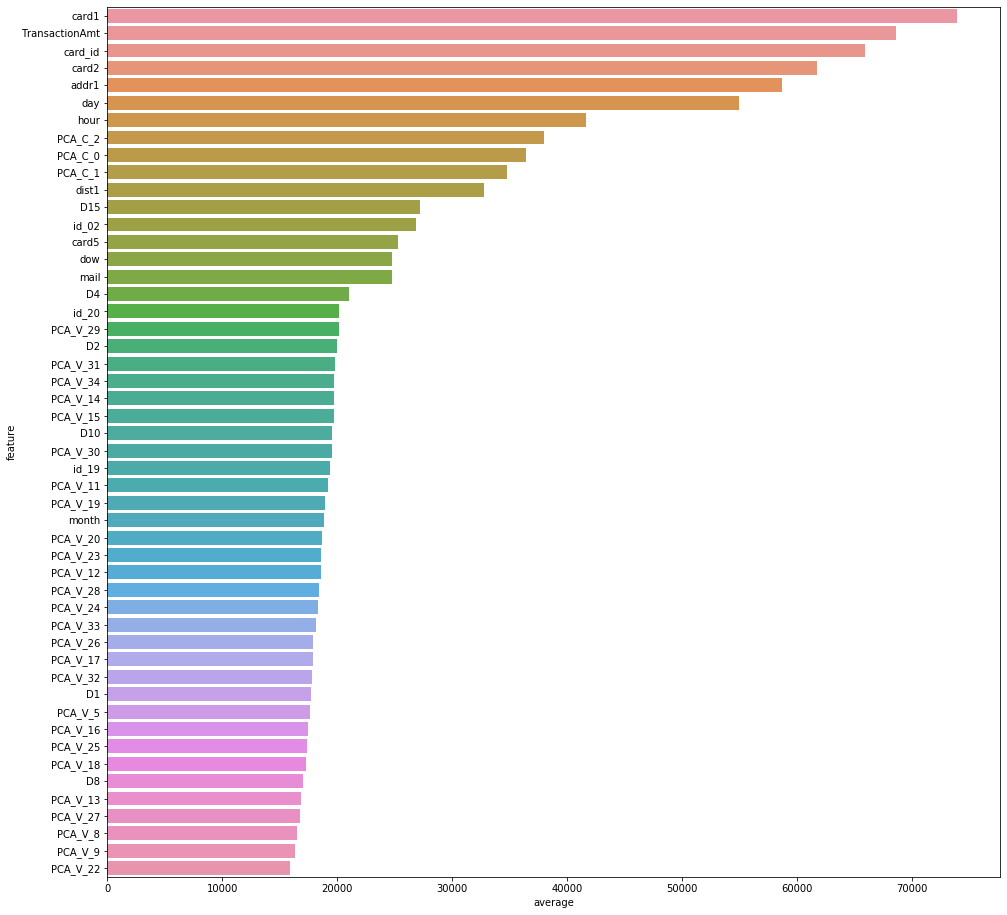

In [446]:
feature['average'] = feature[['fold_'+str(x) for x in range(1,6)]].mean(axis=1)
plt.figure(figsize = (16,16))
sns.barplot(data = feature.sort_values('average', ascending = False).head(50), x = 'average', y = 'feature')

In [449]:
booster = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_booster_round = booster)
clf.fit(X_train, y_train)
test1['prediction1'] = clf.predict_proba(X_test)[:, 1]
test1['prediction2'] = prediction

In [454]:
submission1.to_csv('submission3.csv', index = False)
submission2.to_csv('submission4.csv', index = False)

In [450]:
submission1 = test1[['TransactionID', 'prediction1']].rename({'prediction1': 'isFraud'}, axis=1)
submission2 = test1[['TransactionID', 'prediction2']].rename({'prediction1': 'isFraud'}, axis=1)


In [ ]:
# splits = 5
# folds = KFold(n_splits = splits)
# oof = np.zeros(len(X_train))
# predictions = np.zeros(len(X_test))
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
#     print("Fold {}".format(fold_))
#     train_df, y_train_df = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
#     valid_df, y_valid_df = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
#     trn_data = lgb.Dataset(train_df, label=y_train_df)
#     val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
#     clf = lgb.train(params,
#                     trn_data,
#                     10000,
#                     valid_sets = [trn_data, val_data],
#                     verbose_eval=500,
#                     early_stopping_rounds=500)

#     pred = clf.predict(valid_df)
#     oof[val_idx] = pred
#     print( "  auc = ", roc_auc_score(y_valid_df, pred) )
#     predictions += clf.predict(X_test) / splits

In [399]:
# test1['isFraud'] = predictions
# result = test1[['TransactionID', 'isFraud']]
# result.to_csv('submission.csv', index = False)

In [421]:
# clf.feature_importance()

array([30769,  1622, 37566, 30162,  1298,  3246, 12827,  1613, 28466,
         498, 16101,  6470, 11344, 12060,  6790, 12561,  5356,  2930,
        1070,  8839,  4381, 11606,  7263,  2505,  2069,  3301, 15943,
          19,   639,  1237,  3338,  2648,  2801,  1172,  1159,  1238,
        1973,  7805,  6973,  7985,  7279,  7681, 10265,  8017,  8310,
        9298,  9190,  8606, 10568, 10530,  9204, 11045, 10673,  9307,
        9831,  9152, 10445, 10267,  7887,  8602, 10335, 10057,  9242,
       10024,  9031,  9876, 10760, 10691, 10336,  9850,  9712, 10761,
       20624, 20160, 21803, 12540,  1916,  9491, 10566, 16773, 24322,
       33047,  3908, 11435,   248,  4451,  1716,   632,   434,   966,
        2214,  8946,  9892,   182,   149,   559,   429,    33,   460,
        1203,   926,  4509,  4336,  1003,  2700,  2580,  3260,  3146,
        5676])